# Crochet and Knitting Patterns
Predicting pattern difficulty from pattern attributes 

Ravelry.com hosts tens of thousands of crochet and knitting patterns created by users, some for sale, others offered up for free. Ravelry's free API provides rich detail for each, including features like yarn weight, gauge, yardage, tags, author information, and community ratings for the quality of the pattern as well as its difficulty.

Is it possible to infer how challenging a pattern is to complete from these features? I built a dataset from the API, explored and prepared the data, and fit a simple linear regression model to find out.

In [376]:
import ast
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from pandas.io.json import json_normalize
from scipy.stats import shapiro
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

# refer to pattern_details_ravelry.py for creating this dataset via the Ravelry API
pattern_details = pd.read_csv('~/kp_git/crochet_patterns/pattern_details.csv')

### The Model 
For this analysis, we will use [**linear regression**](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f) to understand the relationship between pattern difficulty and pattern attributes. Assumptions of linear regression include: 

- Linear relationship
- Multivariate normality 
- No multicollinearity 
- Homoskedacity of the residuals 

### Data Exploration 
First, let's inspect the data.  

In [377]:
pattern_details.shape

(6796, 74)

In [378]:
pattern_details.columns

Index(['comments_count', 'created_at', 'currency', 'difficulty_average',
       'difficulty_count', 'downloadable', 'favorites_count', 'free', 'gauge',
       'gauge_divisor', 'gauge_pattern', 'generally_available', 'id', 'name',
       'pdf_url', 'permalink', 'price', 'projects_count', 'published',
       'queued_projects_count', 'rating_average', 'rating_count', 'row_gauge',
       'updated_at', 'url', 'yardage', 'yardage_max', 'personal_attributes',
       'sizes_available', 'product_id', 'currency_symbol', 'ravelry_download',
       'pdf_in_library', 'volumes_in_library', 'gauge_description',
       'yarn_weight_description', 'yardage_description',
       'pattern_needle_sizes', 'notes_html', 'notes', 'packs', 'printings',
       'pattern_categories', 'pattern_attributes', 'photos',
       'download_location.type', 'download_location.free',
       'download_location.url', 'yarn_weight.crochet_gauge', 'yarn_weight.id',
       'yarn_weight.knit_gauge', 'yarn_weight.max_gauge',
      

In [379]:
pattern_details.groupby('craft.permalink').count()['id'].sort_values(ascending = False)

craft.permalink
knitting            3749
crochet             3034
machine-knitting       7
loom-knitting          6
Name: id, dtype: int64

We have about 7000 pattern observations, primarily from the clothing and home categories, and pretty evenly split between knitting and crochet.  

#### The dependent variable  

Next, let's understand the dependent variable, `difficulty_average`, or the average difficulty rating given to a pattern by Ravelry users.  

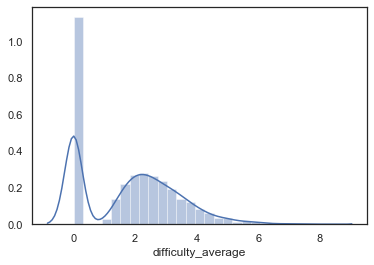

In [380]:
sns.distplot(pattern_details['difficulty_average']);

There are a large number of patterns with a difficulty score of 0, which likely means they have no difficulty ratings.  

In [381]:
pattern_details[pd.isna(pattern_details['difficulty_count'])].shape

(2332, 74)

More than 2200 patterns have `NaN` values for `difficulty_count`. Excluding them refocuses the `difficulty_average` histogram. 

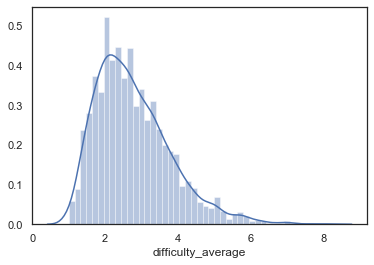

In [382]:
pattern_details = pattern_details[pd.isna(pattern_details['difficulty_count']) == False]

sns.distplot(pattern_details['difficulty_average']);

Is just removing missing values enough? What's the minimum `difficulty_count` that will provide a reliable `difficulty_average` value? 

In [383]:
pattern_details['difficulty_count'].count()

4464

In [384]:
pattern_details.loc[(pattern_details['difficulty_count'] >= 5), 'difficulty_count'].count()

3725

In [385]:
pattern_details.loc[(pattern_details['difficulty_count'] >= 30), 'difficulty_count'].count()

1605

We lose about 700 patterns if we restrict the dataset to observations with at least 5 difficulty ratings. We would lose 2800 if we required 30 ratings. 

In [386]:
pattern_details = pattern_details[pattern_details['difficulty_count'] >= 5]

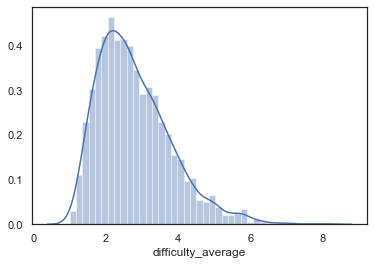

In [387]:
sns.distplot(pattern_details['difficulty_average']);

In [388]:
pattern_details.groupby('craft.permalink').count()['id'].sort_values(ascending = False)

craft.permalink
knitting            2341
crochet             1381
loom-knitting          2
machine-knitting       1
Name: id, dtype: int64

After removing the patterns missing difficulty ratings, the dataset leans slightly more toward knitting than it did before.

One of the central assumptions of linear regression is the normality of the dependent variable. Is `difficulty_average` normally distributed, or do we need to transform it?  

We'll use a [Quantile-Quantile plot, or qqplot,](http://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html) to assess normality. Points along the diagonal indicate a normal distribution.  

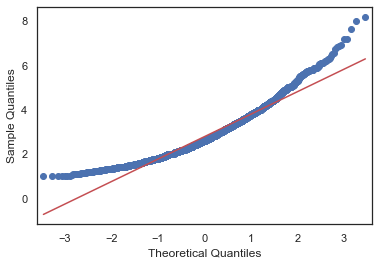

In [389]:
qqplot(pattern_details['difficulty_average'], line = 's');

The data is not normal! Let's try a square root transformation.

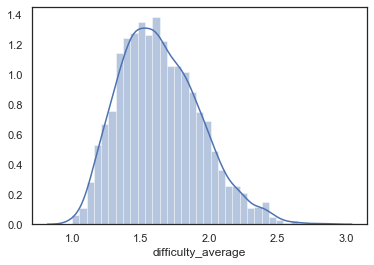

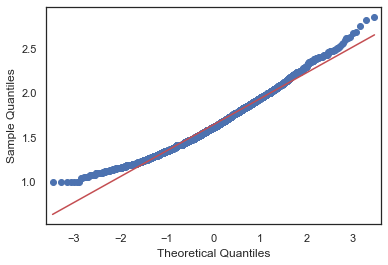

In [390]:
sns.distplot(pattern_details['difficulty_average'].apply(math.sqrt));
qqplot(pattern_details['difficulty_average'].apply(math.sqrt), line = 's');

Close! Let's go one degree further with a cube root.

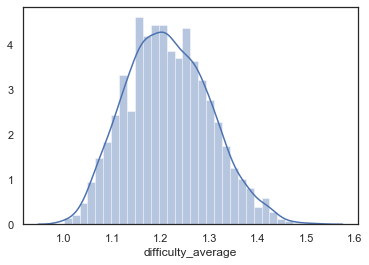

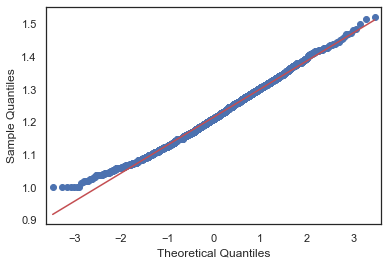

In [391]:
sns.distplot(pattern_details['difficulty_average'].apply(lambda x: x ** (1./5)));
qqplot(pattern_details['difficulty_average'].apply(lambda x: x ** (1./5)), line = 's');

In [392]:
stat, p = shapiro(pattern_details['difficulty_average'].apply(lambda x: x ** (1./5)))
p

2.3840441773503862e-11

In [393]:
pattern_details['difficulty_average_transformed'] = pattern_details['difficulty_average'].apply(lambda x: x ** (1./5))

### Preparing the data for modeling  
Let's create a few binary variables from categorical variables, and use one-hot encoding to prepare the other categorical variables for modeling. 
Next, we'll check the correlation between all variables to see if any are collinear and can be removed. 


In [394]:
# unpack some nested data

# pattern categories
pattern_details['pattern_categories'] = pattern_details['pattern_categories'].apply(ast.literal_eval)

unnested_categories = json_normalize(
    data = json.loads(
        pd.DataFrame.to_json(
            pattern_details, orient = 'records'
        )
    ),
    meta = 'id',
    record_path = 'pattern_categories', 
    record_prefix = 'pattern_categories_', 
    max_level = 1)

pattern_details = pattern_details.merge(
    unnested_categories[['id', 'pattern_categories_parent.name']].drop_duplicates('id'), 
    on = 'id')

# pattern needle sizes
pattern_details['pattern_needle_sizes'] = pattern_details['pattern_needle_sizes'].apply(ast.literal_eval)

unnested_needle_sizes = json_normalize(
    data = json.loads(
        pd.DataFrame.to_json(
            pattern_details, orient = 'records'
        )
    ),
    meta = 'id',
    record_path = 'pattern_needle_sizes', 
    record_prefix = 'pattern_needle_sizes_', 
    max_level = 1)

pattern_details = pattern_details.merge(
    unnested_needle_sizes[['id', 'pattern_needle_sizes_us']].drop_duplicates('id'), 
    on = 'id')

In [397]:
# create binary vars
pattern_details['is_usd'] = pattern_details['currency'].apply(lambda x: 1 if x in ['USD'] else 0)
pattern_details['is_crochet'] = pattern_details['craft.permalink'].apply(lambda x: 1 if x in ['crochet'] else 0)
pattern_details['free'] *= 1

# create smaller strings to encode
pattern_categories_major_groups = ['Clothing', 'Home', 'Sweater', 'Toys and Hobbies', 'Components', 'Hat']
pattern_details['pattern_category_grouped'] = pattern_details['pattern_categories_parent.name'].apply(lambda x: x if x in pattern_categories_major_groups else 'Other')

yarn_weight_major_groups = ['Worsted (9 wpi)', 'DK (11 wpi)', 'Fingering (14 wpi)', 'Aran (8 wpi)','Sport (12 wpi)']
pattern_details['yarn_weight_grouped'] = pattern_details['yarn_weight_description'].apply(lambda x: x if x in yarn_weight_major_groups else 'Other')

needle_size_major_groups = ['4 ','5 ', '6 ', '7 ', '8 ']
pattern_details['needle_size_grouped'] = pattern_details['pattern_needle_sizes_us'].apply(lambda x: x if x in needle_size_major_groups else 'Other')

In [435]:
# remove excess variables from the dataset
encoded_vars = pd.get_dummies(pattern_details[['pattern_category_grouped', 'yarn_weight_grouped', 'needle_size_grouped']])

vars_of_interest = ['pattern_author.patterns_count','price', 'comments_count', 'free', 'is_usd', 'is_crochet',
              'difficulty_average_transformed', 'difficulty_count', 'favorites_count', 
              'projects_count', 'queued_projects_count', 'rating_average', 'rating_count', 
              'gauge', 'gauge_divisor', 'yardage', 'yardage_max']

pattern_details_clean = pattern_details[vars_of_interest].join(encoded_vars)

In [438]:
pattern_corr = pattern_details_clean.corr()

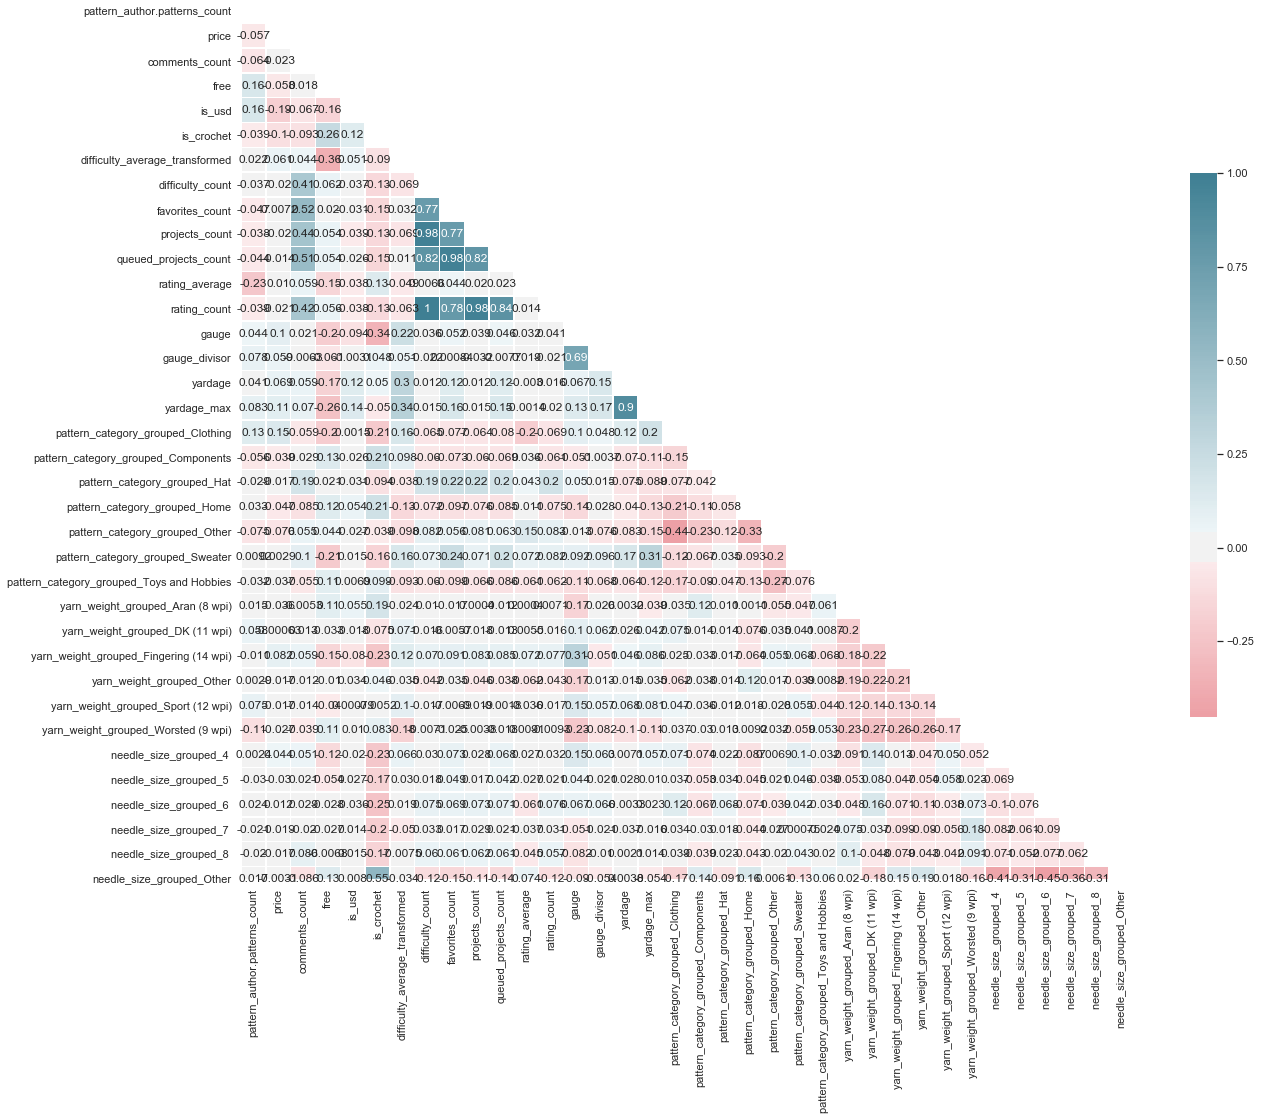

In [440]:
#https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")
plt.figure(figsize=(20,20))
mask = np.zeros_like(pattern_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(pattern_corr, mask = mask, cmap = cmap, center = 0, annot = True, 
            square = True, linewidths=.5, cbar_kws={"shrink": .5});

Several of the count variables are highly correlated (> 0.80) - `projects_count`, `queued_projects_count`, `rating_count` and `difficulty_count`. As would be expected, the encoded `yarn_weight_grouped`, `needle_size_grouped` and `pattern_category_grouped` variables are negatively correlated with each other.  

`is_crochet` is negatively associated with `gauge`, the clothing category, and fingering weight yarn, as well as `price`, `rating_average` and `diffciulty_average`. Crochet patterns are more likely than knit patterns to be `free`, use aran weight yarn, and be in the home or pattern-component categories.   

More difficult patterns are associated with the clothing category, longer `yardage`, higher `gauge`, knitting, fingering weight yarn, and have more comments. 

In [441]:
# remove collinear variables
pattern_details_clean = pattern_details_clean.drop('projects_count', axis = 1)
pattern_details_clean = pattern_details_clean.drop('queued_projects_count', axis = 1)
pattern_details_clean = pattern_details_clean.drop('rating_count', axis = 1)
adjusted_pattern_corr = pattern_details_clean.corr()

### Modelling 
Separate the dataset into the independent variables (X) and the response variable (Y), and then split into 80% training and 20% testing.  


In [475]:
pattern_details_x = pattern_details_clean.drop('difficulty_average_transformed', axis = 1)
pattern_details_y = pattern_details_clean['difficulty_average_transformed']

X = np.array(pattern_details_x)
X = np.nan_to_num(X)

Y = np.array(pattern_details_y).reshape(-1,1)

In [476]:
train_data, test_data, train_response, test_response = train_test_split(X, Y, test_size=0.2, random_state=0)

Fit a linear regression model. 

In [477]:
lm = LinearRegression()
lm.fit(train_data, train_response)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Predict the response variable in the training set, adjusting any outlier predictions back inside the 0,10 `difficulty_average` range. 

In [478]:
train_pred = lm.predict(train_data)
#train_pred[train_pred < 0] = 0
#train_pred[train_pred > 10] = 10
train_rmse = mean_squared_error(train_response, train_pred)
train_r2 = r2_score(train_response, train_pred)
print('RMSE is {} and r2 is {} for the train set'.format(round(train_rmse,3), round(train_r2,3)))

RMSE is 0.005 and r2 is 0.269 for the train set


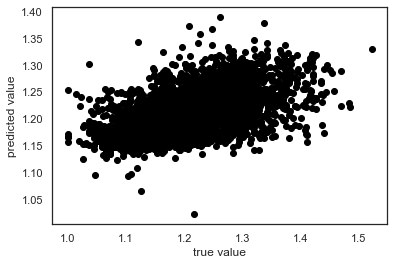

In [479]:
plt.plot(train_response, train_pred, 'o', color = 'black')
plt.xlabel('true value'),
plt.ylabel('predicted value');

Check the residuals for heteroskedacity. Looks good!

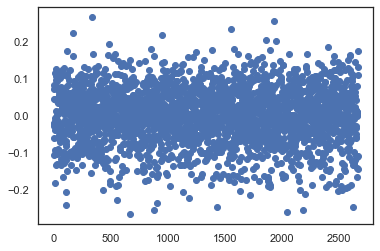

In [480]:
train_residuals = pd.DataFrame(train_pred - train_response)
train_residuals.columns = ['y']
train_residuals['x'] = train_residuals.index
plt.plot(train_residuals['x'], train_residuals['y'], 'o');

Predict the response variable in the test set, adjusting any outlier predictions back inside the 0,10 `difficulty_average` range. 

In [481]:
test_pred = lm.predict(test_data)
#test_pred[test_pred < 0] = 0
#test_pred[test_pred > 10] = 10
test_rmse = mean_squared_error(test_response, test_pred)
test_r2 = r2_score(test_response, test_pred)

print('RMSE is {} and r2 is {} for the test set'.format(round(test_rmse,3), round(test_r2,3)))

RMSE is 0.005 and r2 is 0.26 for the test set


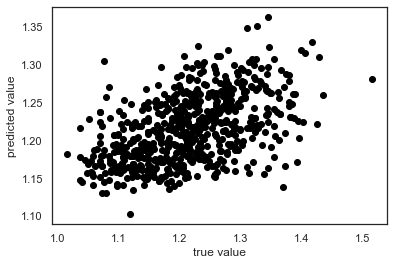

In [482]:
plt.plot(test_response, test_pred, 'o', color = 'black')
plt.xlabel('true value'),
plt.ylabel('predicted value');

Check the residuals.

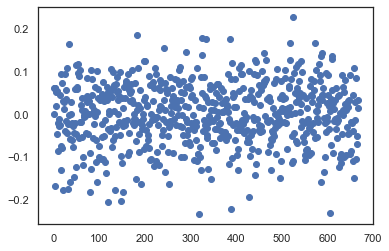

In [483]:
test_residuals = pd.DataFrame(test_pred - test_response)
test_residuals.columns = ['y']
test_residuals['x'] = test_residuals.index
plt.plot(test_residuals['x'], test_residuals['y'], 'o');

With OLS for better output

In [467]:
import statsmodels.formula.api as smf
pattern_details_clean.columns = [c.replace(' ', '_') for c in pattern_details_clean.columns]
pattern_details_clean.columns = [c.replace('.', '_') for c in pattern_details_clean.columns]
pattern_details_clean.columns = [c.replace('(', '') for c in pattern_details_clean.columns]
pattern_details_clean.columns = [c.replace(')', '') for c in pattern_details_clean.columns]
pattern_details_clean.columns

# split
train_data, test_data, train_response, test_response = train_test_split(pattern_details_clean, 
                                                                        pattern_details_clean['difficulty_average_transformed'], 
                                                                        test_size=0.2, 
                                                                        random_state=0)


In [452]:
formula = 'difficulty_average_transformed ~ ' + ' + '.join(train_data.drop('difficulty_average_transformed', axis = 1).columns)
lm2 = smf.ols(formula = formula, data = train_data).fit()

In [453]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     difficulty_average_transformed   R-squared:                       0.245
Model:                                        OLS   Adj. R-squared:                  0.211
Method:                             Least Squares   F-statistic:                     7.243
Date:                            Thu, 02 Jan 2020   Prob (F-statistic):           9.33e-25
Time:                                    15:12:52   Log-Likelihood:                 942.28
No. Observations:                             676   AIC:                            -1825.
Df Residuals:                                 646   BIC:                            -1689.
Df Model:                                      29                                         
Covariance Type:                        nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.0075      0.030     33.226      0.000       0.948       1.067
pattern_author_patterns_count              1.549e-05   1.38e-05      1.124      0.261   -1.16e-05    4.25e-05
price                                       1.94e-05    4.8e-05      0.404      0.686   -7.48e-05       0.000
comments_count                                0.0002      0.000      1.541      0.124   -5.23e-05       0.000
free                                         -0.0283      0.016     -1.814      0.070      -0.059       0.002
is_usd                                       -0.0055      0.005     -1.040      0.299      -0.016       0.005
is_crochet                                    0.0087      0.010      0.872      0.384      -0.011       0.028
difficulty_count                          -5.282e-06   5.66e-06     -0.933      0.351   -1.64e-05    5.84e-06
favorites_count                           -1.067e-06   6.44e-07     -1.657      0.098   -2.33e-06    1.97e-07
rating_average                               -0.0539      0.009     -5.930      0.000      -0.072      -0.036
gauge                                         0.0033      0.001      6.029      0.000       0.002       0.004
gauge_divisor                                -0.0170      0.004     -4.387      0.000      -0.025      -0.009
yardage                                    2.834e-05    8.9e-06      3.185      0.002    1.09e-05    4.58e-05
yardage_max                                7.506e-06    6.2e-06      1.210      0.227   -4.67e-06    1.97e-05
pattern_category_grouped_Clothing             0.1458      0.007     20.656      0.000       0.132       0.160
pattern_category_grouped_Components           0.1510      0.022      6.996      0.000       0.109       0.193
pattern_category_grouped_Hat                  0.1327      0.015      9.079      0.000       0.104       0.161
pattern_category_grouped_Home                 0.1503      0.013     11.815      0.000       0.125       0.175
pattern_category_grouped_Other                0.1450      0.007     19.382      0.000       0.130       0.160
pattern_category_grouped_Sweater              0.1685      0.009     18.459      0.000       0.151       0.186
pattern_category_grouped_Toys_and_Hobbies     0.1143      0.016      7.205      0.000       0.083       0.145
yarn_weight_grouped_Aran_8_wpi                0.1557      0.009     17.256      0.000       0.138       0.173
yarn_weight_grouped_DK_11_wpi                 0.1749      0.007     23.884      0.000       0.161       0.189
yarn_weight_grouped_Fingering_14_wpi          0.1689      0.008     22.140      0.000      

In [473]:
test_pred = lm2.predict(test_data.drop('difficulty_average_transformed', axis = 1))
#test_pred = test_pred.dropna()
test_pred[np.isnan(test_pred)] = 0
#test_pred[test_pred < 0] = 0
#test_pred[test_pred > 10] = 10
test_rmse = mean_squared_error(test_response, test_pred)
test_r2 = r2_score(test_response, test_pred)

print('RMSE is {} and r2 is {} for the test set'.format(round(test_rmse,3), round(test_r2,3)))

RMSE is 1.067 and r2 is -148.842 for the test set


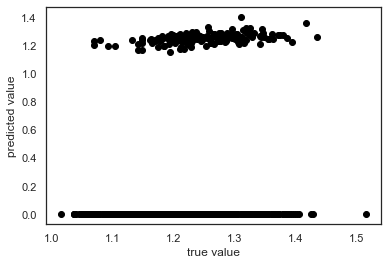

In [471]:
plt.plot(test_response, test_pred, 'o', color = 'black')
plt.xlabel('true value'),
plt.ylabel('predicted value');

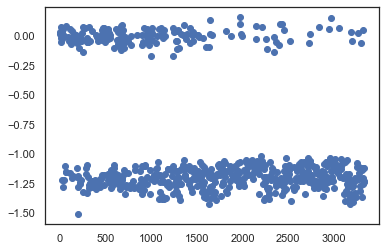

In [472]:
test_residuals = pd.DataFrame(test_pred - test_response)
test_residuals.columns = ['y']
test_residuals['x'] = test_residuals.index
plt.plot(test_residuals['x'], test_residuals['y'], 'o');